In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
kritanjalijain_music_midi_dataset_path = kagglehub.dataset_download('kritanjalijain/music-midi-dataset')

print('Data source import complete.')


100%|██████████| 55.5k/55.5k [00:00<00:00, 43.5MB/s]

Extracting files...
Data source import complete.


In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt

In [ ]:
import math

In [ ]:
!pip install pretty_midi
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 44.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.8 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592286 sha256=c93b19b452a7ad6375359ddaa3094712227785513a2a6cf8320e88c3a911b87e
  Stored in directory: /root/.cache/pip/wheels/e6/95/ac/15ceaeb2823b04d8e638fd1495357adb8d26c00ccac9d7782e
Successfully built pretty_midi
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin
  libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5
  libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xin

In [ ]:
sampling_rate = 10000

In [ ]:
import collections
import datetime
import fluidsynth
import glob
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
from IPython import display
from typing import Dict, List, Optional, Sequence, Tuple

In [ ]:
import glob

filenames = glob.glob("/content/midi_dataset/**/*.mid*", recursive=True)
print(f"Found {len(filenames)} MIDI files.")


Found 50 MIDI files.


In [ ]:
sample_file ="/content/midi_dataset/x (11).mid"
pm = pretty_midi.PrettyMIDI(sample_file)

/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


In [ ]:
def display_audio(pm, seconds=30):
      waveform = pm.fluidsynth(fs=sampling_rate)
  # Take a sample of the generated waveform to mitigate kernel resets
      waveform_short = waveform[:seconds*sampling_rate]
      return display.Audio(waveform_short, rate=sampling_rate)

In [ ]:
display_audio(pm,50)

In [ ]:
print(pm.instruments)
instrument = pm.instruments[0]

[Instrument(program=91, is_drum=False, name="Lead"), Instrument(program=73, is_drum=False, name="Voice"), Instrument(program=87, is_drum=False, name="Bass"), Instrument(program=0, is_drum=True, name="Drums")]


In [ ]:
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)

In [ ]:
for i , note in enumerate(instrument.notes[:10]):
    note_name = pretty_midi.note_number_to_name(note.pitch)
    duration = note.end - note.start
    print(f"{i}: pitch = {note.pitch} , note_name = {note_name} , duration = {duration:.4f}")

0: pitch = 77 , note_name = F5 , duration = 0.2500
1: pitch = 77 , note_name = F5 , duration = 0.2500
2: pitch = 75 , note_name = D#5 , duration = 0.2500
3: pitch = 77 , note_name = F5 , duration = 0.2500
4: pitch = 79 , note_name = G5 , duration = 0.2500
5: pitch = 72 , note_name = C5 , duration = 0.2500
6: pitch = 75 , note_name = D#5 , duration = 0.2500
7: pitch = 77 , note_name = F5 , duration = 0.2500
8: pitch = 77 , note_name = F5 , duration = 0.2500
9: pitch = 75 , note_name = D#5 , duration = 0.2500


In [ ]:
def midi_to_notes(midi_file):
    pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = pm.instruments[0]
    notes = collections.defaultdict(list)
    sorted_notes = sorted(instrument.notes , key=lambda note:note.start)
    prev_start = sorted_notes[0].start

    for note in sorted_notes:
        start = note.start
        end = note.end
        notes["pitch"].append(note.pitch)
        notes["start"].append(start)
        notes["end"].append(end)
        notes["step"].append(start - prev_start)
        notes["duration"].append(end - start)
        prev_start = start
    return pd.DataFrame({name:np.array(value) for name,value in notes.items()})

In [ ]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,77,0.00,0.25,0.00,0.25
1,77,1.00,1.25,1.00,0.25
2,75,1.75,2.00,0.75,0.25
3,77,2.00,2.25,0.25,0.25
4,79,2.25,2.50,0.25,0.25


In [ ]:
note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = note_names(raw_notes["pitch"])
sample_note_names[:10]

array(['F5', 'F5', 'D#5', 'F5', 'G5', 'C5', 'D#5', 'F5', 'F5', 'D#5'],
      dtype='<U3')

In [ ]:
def plot(notes , count):
    if count:
        title = f"first {count} notes"
    else:
        title = f"whole track"
        count = len(notes["pitch"])
    plt.figure(figsize=(20,4))
    plot_pitch = np.stack([notes["pitch"] , notes["pitch"]],axis = 0)
    plot_start_stop = np.stack([notes["start"] , notes["end"]] ,axis = 0)
    print(plot_start_stop.shape)
    plt.plot(plot_start_stop[:,:count] , plot_pitch[:,:count] , color ="r" ,marker = "*")
    plt.xlabel("Time [s]")
    plt.ylabel("pitch")
    plt.title = title

(2, 23)


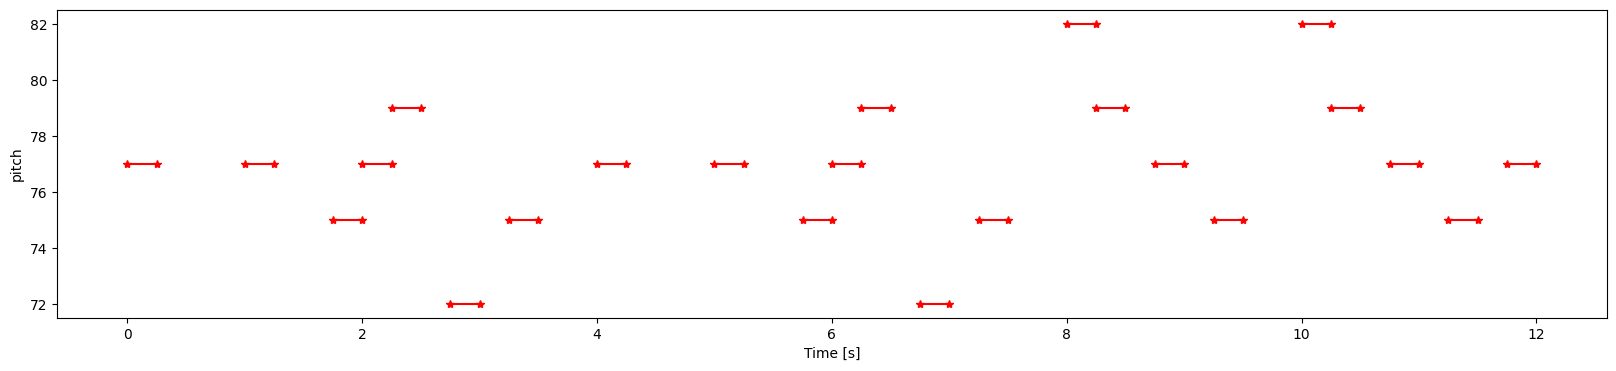

In [ ]:
plot(raw_notes , count=100)

In [ ]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str,
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [ ]:
num_files = 5
all_notes = []
for f in filenames[:num_files] :
    notes = midi_to_notes(f)
    all_notes.append(notes)
all_notes = pd.concat(all_notes)


/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


In [ ]:
print(all_notes)

    pitch   start     end   step  duration
0      73   4.250   4.500  0.000     0.250
1      75   4.500   4.750  0.250     0.250
2      68   4.750   5.000  0.250     0.250
3      68   5.000   5.250  0.250     0.250
4      66   5.250   5.500  0.250     0.250
..    ...     ...     ...    ...       ...
29     64  29.750  29.875  0.375     0.125
30     66  30.375  30.500  0.625     0.125
31     67  31.375  31.500  1.000     0.125
32     64  31.625  31.750  0.250     0.125
33     66  31.750  31.875  0.125     0.125

[610 rows x 5 columns]


In [ ]:
n_notes = len(all_notes)
print(n_notes)

610


In [ ]:
key_order = ["pitch" , "step" , "duration"]
train_notes = np.stack([all_notes[key] for key in key_order] , axis = 1)

In [ ]:
print(train_notes[:20,0])

[73. 75. 68. 68. 66. 70. 73. 73. 73. 73. 68. 68. 66. 68. 68. 68. 66. 70.
 73. 73.]


In [ ]:
notes_ds=tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [ ]:
seq_length = 20
vocab_size = 128


In [ ]:
print(train_notes.shape)

(610, 3)


In [ ]:
def create_sequences(dataset,seq_length,vocab_size=128):
    sequences = []
    targets = []
    num_seq = train_notes.shape[0] - seq_length
    for i in range(num_seq):
        sequence = train_notes[i:i+seq_length - 1,:] / [vocab_size, 1 ,1]
        target =  train_notes[i+seq_length] / vocab_size
        sequences.append(sequence)
        targets.append(target)
    sequences = np.array(sequences)
    targets = np.array(targets)
    print(sequences.shape , targets.shape)
    dataset = tf.data.Dataset.from_tensor_slices((sequences,{"pitch":targets[:,0] , "step":targets[:,1] ,"duration" :targets[:,2]}))
    return dataset

In [ ]:
seq_ds = create_sequences(notes_ds, 21, vocab_size)

(589, 20, 3) (589, 3)


In [ ]:
for seq, target in seq_ds.take(1):
    print("sequence shape: " , seq.shape )
    print("sequence elements " ,seq[0:10])
    print()
    print("target ", target)

sequence shape:  (20, 3)
sequence elements  tf.Tensor(
[[0.5703125 0.        0.25     ]
 [0.5859375 0.25      0.25     ]
 [0.53125   0.25      0.25     ]
 [0.53125   0.25      0.25     ]
 [0.515625  0.25      0.25     ]
 [0.546875  0.25      0.25     ]
 [0.5703125 0.5       0.125    ]
 [0.5703125 0.125     0.125    ]
 [0.5703125 0.125     0.125    ]
 [0.5703125 0.125     0.125    ]], shape=(10, 3), dtype=float64)

target  {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=0.5703125>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.0009765625>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.0009765625>}


In [ ]:
batch_size =64
buffer_size = 5000
train_ds = seq_ds.shuffle(buffer_size).batch(batch_size)

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(None, 20, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(None,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(None,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(None,), dtype=tf.float64, name=None)})

In [ ]:
layer = tf.keras.layers
learning_rate = 0.005
input_data = tf.keras.Input(shape=(seq_length , 3))
x= layer.LSTM(128)(input_data)
outputs = {
    "pitch":tf.keras.layers.Dense(128 , name = "pitch")(x),
    "step":tf.keras.layers.Dense(1 , name = "step")(x),
    "duration":tf.keras.layers.Dense(1 , name = "duration")(x),
}
model = tf.keras.Model(input_data , outputs)

loss  ={
    "pitch" : tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    "step": tf.keras.losses.MeanSquaredError(),
    "duration":tf.keras.losses.MeanSquaredError(),
}

optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
model.compile(loss=loss ,    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    }, optimizer = optimizer)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 20, 3)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 128)            │         67,584 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ duration (Dense)          │ (None, 1)              │            129 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pitch (Dense)             │ (None, 128)            │         16,512 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ step (Dense)              │ (None, 1)              │            129 │ lstm[0][0]             │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 84,354 (329.51 KB)

 Trainable params: 84,354 (329.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(train_ds , epochs = 100)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - duration_loss: 0.0307 - loss: 0.2717 - pitch_loss: 4.7720 - step_loss: 0.0020
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - duration_loss: 0.0040 - loss: 0.1889 - pitch_loss: 3.4816 - step_loss: 0.0089
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - duration_loss: 0.0069 - loss: 0.0551 - pitch_loss: 0.0223 - step_loss: 0.0467
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - duration_loss: 0.0025 - loss: 0.0095 - pitch_loss: 0.0083 - step_loss: 0.0065
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - duration_loss: 2.3061e-04 - loss: 0.0041 - pitch_loss: 0.0060 - step_loss: 0.0035
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - duration_loss: 3.0570e-04 - loss: 0.0017 - pitch_loss: 0.0049 - step_loss: 0.0011
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - duration_loss: 1.0688e-04 - loss: 7.4443e-04 - pitch_loss: 0.0041 - step_loss: 4.2845e-04
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - du

In [ ]:
hist = model.predict(train_ds)
print(hist["duration"].shape)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
(589, 1)


In [ ]:
print(hist["step"].shape)

(589, 1)


In [ ]:
def predict_next_note(
notes , keras_model , temperature):

    assert temperature > 0
    inputs = np.expand_dims(notes , 0)
    predictions = model.predict(inputs)
    pitch_logits = predictions['pitch']
    step = predictions["step"]
    duration = predictions["duration"]
    pitch_logits /= temperature
    pitch = tf.random.categorical(pitch_logits , num_samples = 1)
    pitch = tf.squeeze(pitch , axis = -1)
    duration = tf.squeeze(duration , axis =-1)
    step = tf.squeeze(step,axis = -1)
    step = tf.maximum(0,step)
    duration = tf.maximum(0 , duration)
    return int(pitch) , float(step) , float(duration)

In [ ]:
temperature = 2.0
num_predictions = 1200

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
      pitch, step, duration = predict_next_note(input_notes, model, temperature)
      start = prev_start + step
      end = start + duration
      input_note = (pitch, step, duration)
      generated_notes.append((*input_note, start, end))
      input_notes = np.delete(input_notes, 0, axis=0)
      input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
      prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━

In [ ]:
generated_notes.head(40)


,pitch,step,duration,start,end
0,0,0.003724,0.0,0.003724,0.003724
1,0,0.001055,0.0,0.004780,0.004780
2,0,0.001822,0.0,0.006602,0.006602
3,0,0.002708,0.0,0.009310,0.009310
4,0,0.003211,0.0,0.012521,0.012521
5,80,0.003495,0.0,0.016016,0.016016
6,0,0.300535,0.0,0.316552,0.316552
7,0,0.000000,0.0,0.316552,0.316552
8,0,0.000000,0.0,0.316552,0.316552
9,0,0.000000,0.0,0.316552,0.316552


In [ ]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm , 1800)